In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import regex as re
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the datasets

train_data = pd.read_csv('Genre Classification Dataset/train_data.txt',delimiter=':::',names=['Title','Genre','Description'])
test_data = pd.read_csv('Genre Classification Dataset/test_data.txt',delimiter=':::',names=['Title','Description'])
test_sol = pd.read_csv('Genre Classification Dataset/test_data_solution.txt',delimiter=':::',names=['Title','Genre','Description'])

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54200 entries, 1 to 54200
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
# Check for null values
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [6]:
test_data.isnull().sum()

Title          0
Description    0
dtype: int64

In [7]:
# Shifting the target variable to the last column

columns = ['Title','Description','Genre']
train_data = train_data[columns]
train_data.head()

,Title,Description,Genre
1,Oscar et la dame rose (2009),Listening in to a conversation between his do...,drama
2,Cupid (1997),A brother and sister with a past incestuous r...,thriller
3,"Young, Wild and Wonderful (1980)",As the bus empties the students for their fie...,adult
4,The Secret Sin (1915),To help their unemployed father make ends mee...,drama
5,The Unrecovered (2007),The film's title refers not only to the un-re...,drama


In [8]:
test_data.head()

,Title,Description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


In [9]:
# Total no of genre
train_data['Genre'].nunique()

27

In [10]:
# Types of genre the moives belong to
train_data['Genre'].unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [11]:
# No of movies in each genre
train_data['Genre'].value_counts()

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: Genre, dtype: int64

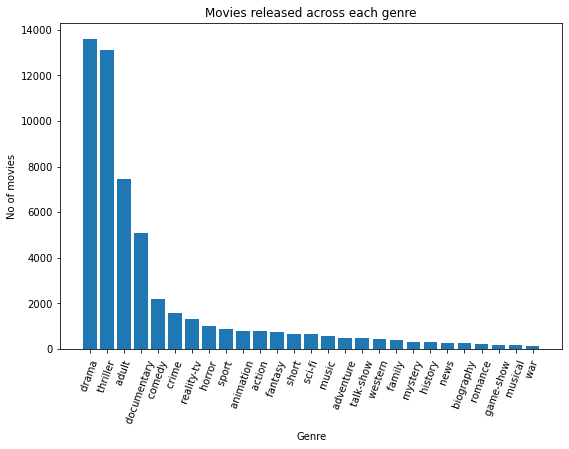

In [12]:
# Plotting the distribution of movies across each genre

plt.figure(figsize=(9,6))
plt.bar(train_data['Genre'].unique(),train_data['Genre'].value_counts())
plt.title('Movies released across each genre')
plt.xlabel('Genre')
plt.ylabel('No of movies')
plt.xticks(rotation = 70)
plt.show()

#### Splitting the data

In [13]:
# Splitting the training data 

x_train = train_data.iloc[:,1].values # Considering only the movie description as a feature to predict the genre of the movie 
y_train = train_data.iloc[:,-1].values

# Selecting the testing data
x_test = test_data.iloc[:,-1].values # Considering only the movie description as a feature to predict the genre of the movie 

#### Text Preprocessing

In [14]:
def process_text(text):
    ''' This function performing text cleaning & converts words into it's base form '''
    
    # Convert to lowercase
    sentence = text.lower()
    
    # Removing username
    sentence = re.sub(r'@[a-zA-Z0-9_.]+','',sentence) 
    
    # Removing URLs
    sentence = re.sub(r"https?://\S+|www\.\S+",'',sentence)
    
    # Character normalization 
    sentence = re.sub(r"([a-zA-Z])\1{2,}", r'\1', sentence)
    
    # Removing punctuations 
    sentence = re.sub(r'[^\w\s]','',sentence)
    
    # Removing stopwords & converting to lowercase
    english_stop = stopwords.words('english')
    sentence = ' '.join([word for word in sentence.split() if word not in english_stop])
    
    # Performing word tokenization
    sentence = word_tokenize(sentence) # Returns a list of words
    
    # Performing lemmatization
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence])
    
    return sentence

In [15]:
# Applying text cleaning & preprocessing techniques on the text data

x_train = [process_text(desc) for desc in x_train]
x_test = [process_text(desc) for desc in x_test]

In [16]:
# Representing the processed text as a list of words

x_train_low = [desc.split() for desc in x_train]
x_test_low = [desc.split() for desc in x_test]

#### Creating a vocabulary

In [17]:
vocab = []

for desc in x_train_low:
    for word in desc:
        if word not in vocab:
            vocab.append(word)

In [18]:
print("Size of vocabulary: ",len(vocab))

Size of vocabulary:  139768


#### Creating feature vectors

#### TF- IDF 

In [19]:
# Applying TF-IDF vectorizer

tf_idf = TfidfVectorizer(max_features = 5000)
train_vector = tf_idf.fit_transform(x_train)
test_vector = tf_idf.transform(x_test)

#### Word2Vec

In [20]:
model = Word2Vec(sentences = x_train_low, vector_size = 100, epochs = 5, workers = 5)

In [21]:
words_in_model = model.wv.index_to_key

In [22]:
def word_in_vocab(sentence):
    ''' This fn checks if all the words present in the sentence is part of the vocabulary of the model or not '''
    
    total = 0
    no_of_words = len(sentence)
    
    for word in sentence:
        if word in words_in_model:
            total += 1
            
    if total != no_of_words: 
    # If all words are not present in vocab of the model, we create a numpy array of zeros of same dimension as the word vector
        return False 
    else:
        return True

In [23]:
# Creating train data & test data word vectors
train_wv = [model.wv[sentence].sum(axis = 0) if len(sentence) != 0 and word_in_vocab(sentence) else np.zeros((100)) for sentence in x_train_low]
test_wv = [model.wv[sentence].sum(axis = 0) if len(sentence) != 0 and word_in_vocab(sentence) else np.zeros((100)) for sentence in x_test_low]

#### Model Training using TF - IDF vectors

#### Logistic Regression

In [34]:
log_reg = LogisticRegression()
log_reg.fit(train_vector,y_train)

LogisticRegression()

In [25]:
log_pred = log_reg.predict(train_vector)
print('Accuracy Score: ',round(accuracy_score(log_pred,y_train),2))

Accuracy Score:  0.67


#### Naive Bayes

In [26]:
nb = GaussianNB()
nb.fit(train_vector.todense(),y_train)

GaussianNB()

In [27]:
nb_pred = nb.predict(train_vector.todense())
print('Accuracy Score: ',round(accuracy_score(nb_pred,y_train),2))

Accuracy Score:  0.36


<b>Logistic Regression gives a better accuracy score compared to Naive Bayes in case of TF-IDF vectors.</b>

#### Model Training using Word2Vec word embeddings

#### Logistic Regression

In [28]:
log_r = LogisticRegression()
log_r.fit(train_wv,y_train)

LogisticRegression()

In [29]:
log_p = log_r.predict(train_wv)
print('Accuracy Score: ',round(accuracy_score(log_p,y_train),2))

Accuracy Score:  0.32


#### Naive Bayes

In [30]:
nb = GaussianNB()
nb.fit(train_wv,y_train)

GaussianNB()

In [31]:
nb_pred = nb.predict(train_wv)
print('Accuracy Score: ',round(accuracy_score(nb_pred,y_train),2))

Accuracy Score:  0.06


#### We get better results with TF - IDF vector representations compared to Word2Vec word embeddings

<b> We will use Logistic Regression model trained using TF - IDF vectors that yields 67% accuracy(for train data) for prediction </b>

In [35]:
# Prediction on test data
test_pred = log_reg.predict(test_vector)

In [36]:
test_sol['Predicted'] = test_pred

In [37]:
test_sol.head()

,Title,Genre,Description,Predicted
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",drama
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",short
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,drama
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",short
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,comedy


In [38]:
# No of correct predictions

total_movies = len(test_sol)
correct_predictions = 0

for movie in range(1,total_movies+1):
    if test_sol['Genre'][movie] == test_sol['Predicted'][movie]:
        correct_predictions += 1
    
print("Total no of movie genre predicted: ",total_movies,"\nNo of movie genre predicted right: ",correct_predictions,
      "\nPercentage of correct predictions: ",round((correct_predictions/total_movies)*100,0),"%")

Total no of movie genre predicted:  54200 
No of movie genre predicted right:  12370 
Percentage of correct predictions:  23.0 %
